# Проект: классификация

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [2]:
df = pd.read_csv('bank_fin.csv', sep = ';')

In [3]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
# ваш код
df.info()
df['balance'].isnull().value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


False    11137
True        25
Name: balance, dtype: int64

### Задание 2

In [4]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
# ваш код
df['job'].value_counts()

management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64

### Задание 3

In [5]:
df['balance']

0         2 343,00 $ 
1            45,00 $ 
2         1 270,00 $ 
3         2 476,00 $ 
4           184,00 $ 
             ...     
11157         1,00 $ 
11158       733,00 $ 
11159        29,00 $ 
11160           0  $ 
11161           0  $ 
Name: balance, Length: 11162, dtype: object

In [6]:
def make_convert(row):
    row = str(row)
    if row != 'unknown':
        row = row.replace(',00', '')
        row = row.replace('$', '')
        row = row.replace(' ', '')
        return float(row)
    else:
        return np.nan

In [7]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
df['balance'] = df['balance'].apply(make_convert)

In [8]:
df['balance'].mean()

1529.1290293615875

### Задание 4

In [9]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
# ваш код
df['balance'] = df['balance'].fillna(df['balance'].median())

In [10]:
round(df['balance'].mean(),3)

1526.936

### Задание 5

In [11]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
# ваш код
print(df.job.value_counts())
print('-----------------------------')
df['job'][df['job'] == 'unknown'] = ['management']
print(df.job.value_counts())

management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64
-----------------------------
management       2636
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
Name: job, dtype: int64


Решил наглядно посмотреть каr изменения

In [12]:
print(df.education.value_counts())
print('-----------------------------')
df['education'][df['education'] == 'unknown'] = ['secondary']
print(df.education.value_counts())

secondary    5476
tertiary     3689
primary      1500
unknown       497
Name: education, dtype: int64
-----------------------------
secondary    5973
tertiary     3689
primary      1500
Name: education, dtype: int64


Обработка уровня образования

In [13]:
round(df.loc[(df['job'] == 'management') & (df['education'] == 'secondary')]['balance'].mean(), 3)

1598.883

##  Задание 2.6

In [14]:
df['balance'].describe()

count    11162.000000
mean      1526.936033
std       3224.829691
min      -6847.000000
25%        123.000000
50%        550.000000
75%       1699.000000
max      81204.000000
Name: balance, dtype: float64

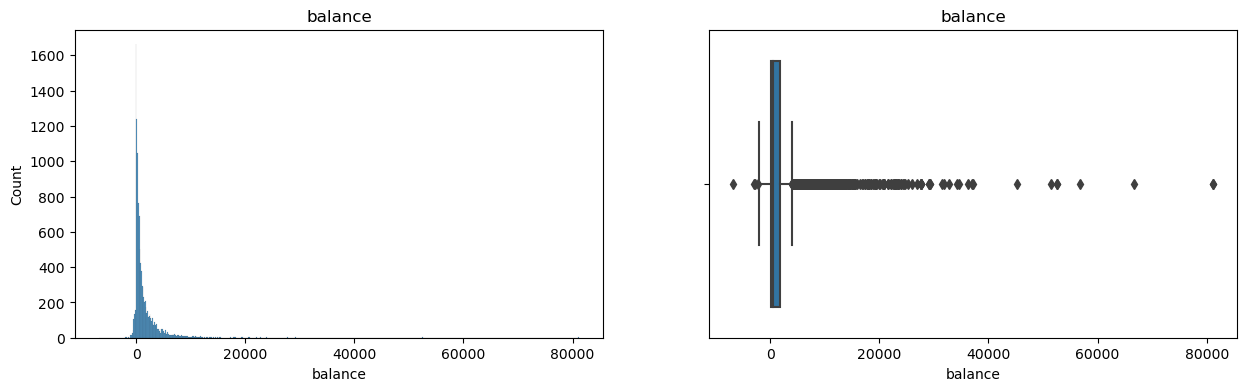

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=df, x='balance', ax=axes[0]);
histplot.set_title('balance');
boxplot = sns.boxplot(data=df, x='balance', ax=axes[1]);
boxplot.set_title('balance');

МЕТОД МЕЖКВАРТИЛЬНОГО РАЗМАХА (МЕТОД ТЬЮКИ)

Воспользуемся нашей старой знакомой наглядной функцией для определения выбросов

In [16]:
def outliers_iqr(data, feature):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    print(f'верхняя и нижняя граница: {upper_bound, lower_bound}')
    outliers = data[(x<lower_bound) | (x >= upper_bound)]
    cleaned = data[(x>lower_bound) & (x <= upper_bound)]
    return outliers, cleaned

In [17]:
outliers, cleaned = outliers_iqr(df, 'balance')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

верхняя и нижняя граница: (4063.0, -2241.0)
Число выбросов по методу Тьюки: 1058
Результирующее число записей: 10105


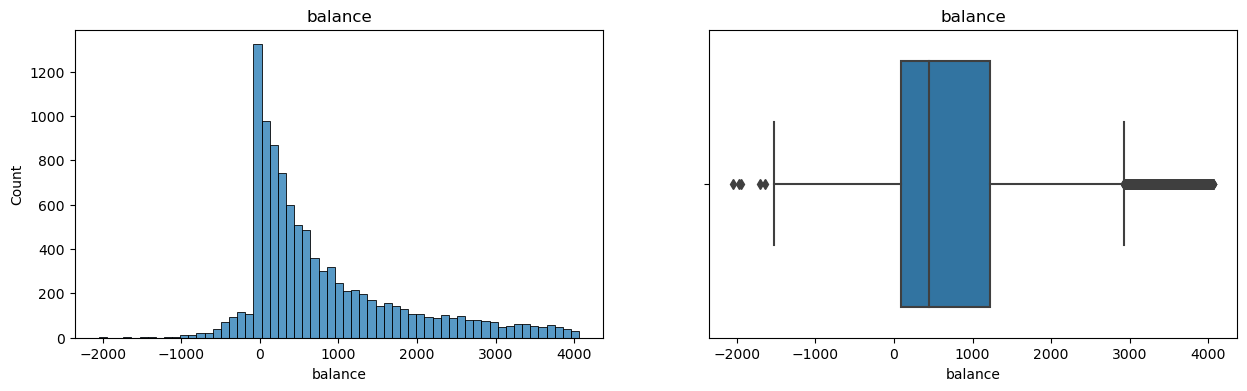

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=cleaned, x='balance', ax=axes[0]);
histplot.set_title('balance');
boxplot = sns.boxplot(data=cleaned, x='balance', ax=axes[1]);
boxplot.set_title('balance');

Данык похожи на лог номальные и по хорошему наверно следовало логарифмировать,
но задание от нас этого не требует

Выбросов около 10%- это очень много

In [19]:
# удалите все выбросы для признака balance
# ваш код
df = cleaned

## Часть 2:  Разведывательный анализ

### Задание 1

no     5424
yes    4681
Name: deposit, dtype: int64


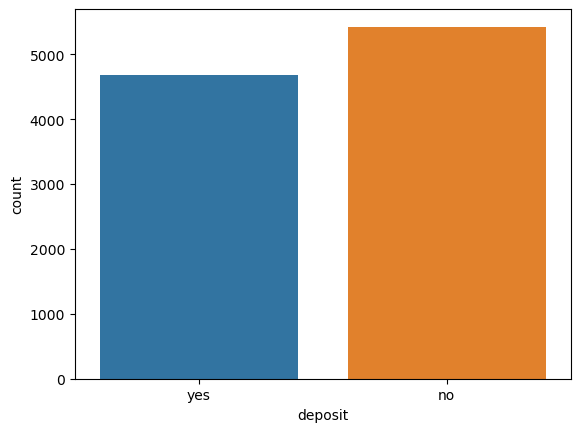

In [20]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
# ваш код
print(df.deposit.value_counts())
sns.countplot(x ='deposit', data = df)
plt.show()

### Задания 2 и 3

In [21]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
#ваш код
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


### Задания 4 и 5

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570,5424


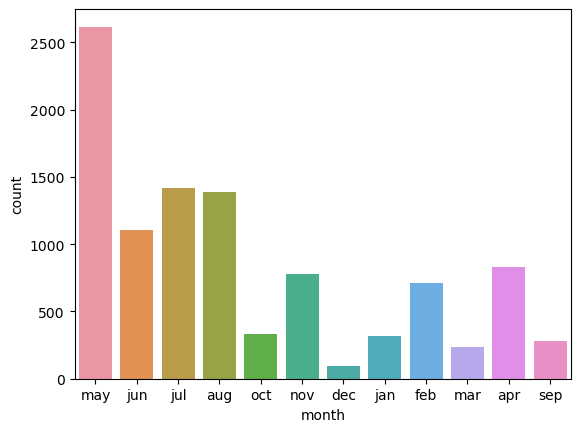

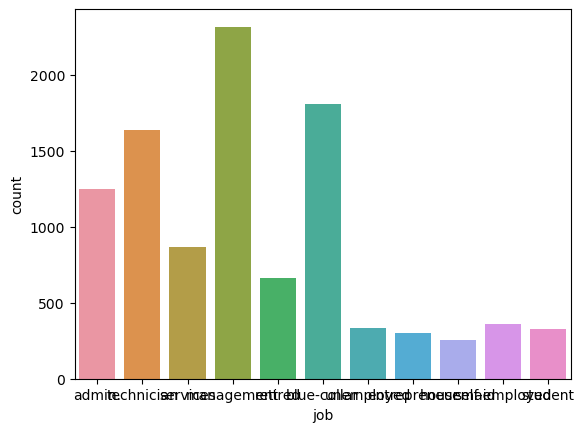

In [22]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
#ваш код
display(df.describe(include = 'object'))
#постройте визуализации, иллюстрирующие результаты
# count plot on single categorical variable
sns.countplot(x ='month', data = df)
plt.show()
sns.countplot(x ='job', data = df)
# Show the plot
plt.show()

### Задание 6

<AxesSubplot:xlabel='poutcome'>

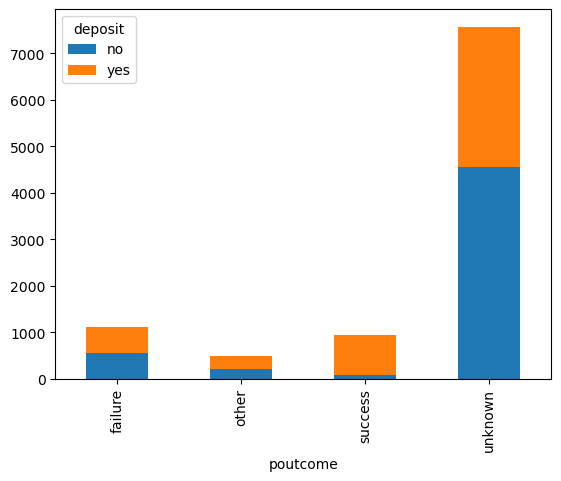

In [23]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
# ваш код
types = df.groupby('poutcome')['deposit'].value_counts(normalize=False).unstack()
types.plot(kind='bar', stacked='True')

### Задание 7

deposit        no       yes
month                      
may      0.678640  0.321360
jan      0.608150  0.391850
jul      0.589563  0.410437
nov      0.584615  0.415385
aug      0.559567  0.440433
jun      0.548913  0.451087
feb      0.455571  0.544429
apr      0.381928  0.618072
oct      0.185075  0.814925
sep      0.165468  0.834532
mar      0.101266  0.898734
dec      0.096774  0.903226


<AxesSubplot:xlabel='month'>

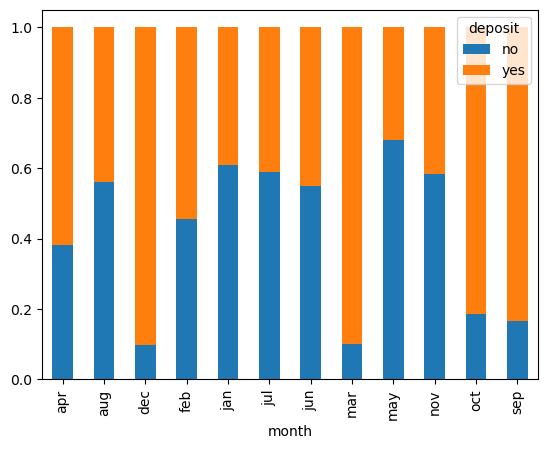

In [24]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
# ваш код
month = df.groupby('month')['deposit'].value_counts(normalize=True).unstack()
print(pd.DataFrame(month.sort_values('yes')))
month.plot(kind='bar', stacked='True')

### Задание 8

<AxesSubplot:xlabel='age_group', ylabel='count'>

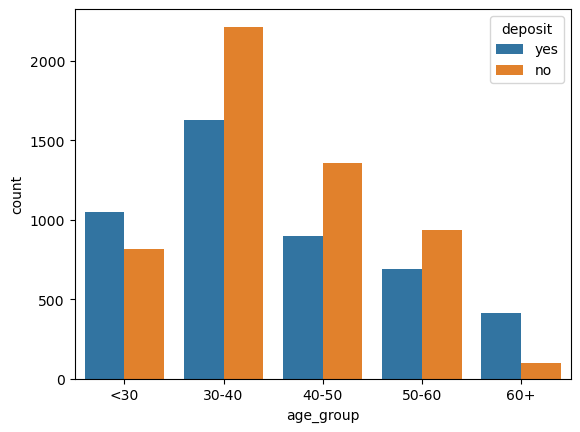

In [25]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения
df['age_group'] = pd.cut(df.age, [0,30,40,50,60,9999], labels = ['<30','30-40','40-50','50-60','60+'])
sns.countplot(x="age_group", hue="deposit", data=df)

### Задания 9 и 10

AxesSubplot(0.125,0.11;0.775x0.77)
management       2315
blue-collar      1807
technician       1638
admin.           1246
services          868
retired           663
self-employed     358
unemployed        332
student           326
entrepreneur      300
housemaid         252
Name: job, dtype: int64
['married' 'single' 'divorced']


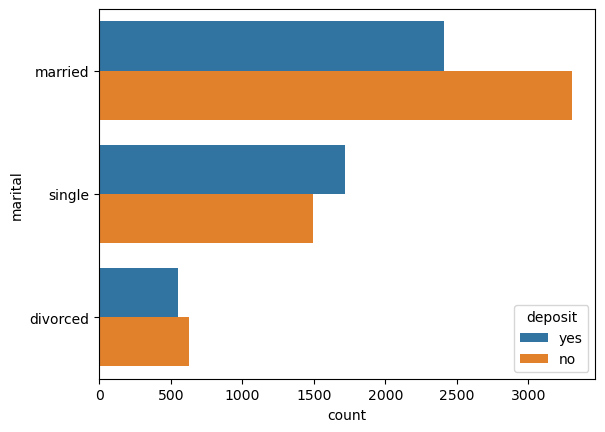

In [26]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса
print(sns.countplot(y='marital', hue='deposit', data=df))
print(df.job.value_counts())
print(df['marital'].unique())

### Задание 11

marital    divorced  married  single
education                           
primary          96      339      82
secondary       283     1289     879
tertiary        174      784     755


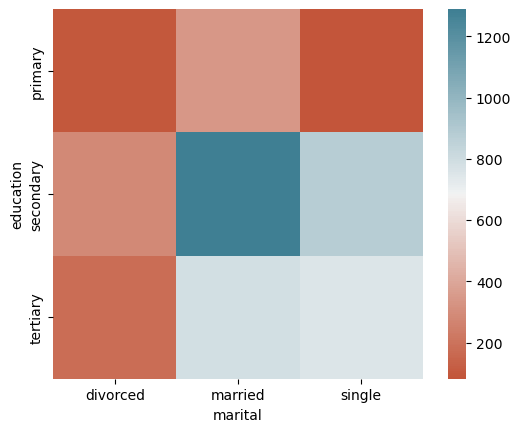

In [27]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)
# print(df.columns)
deposit_yes = df[df.deposit=='yes']

crosstab_yes_df = pd.crosstab(deposit_yes.education, deposit_yes.marital)
print(crosstab_yes_df)
ax = sns.heatmap(
    crosstab_yes_df,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
)



marital    divorced  married  single
education                           
primary          91      641     100
secondary       370     1830     866
tertiary        163      832     531


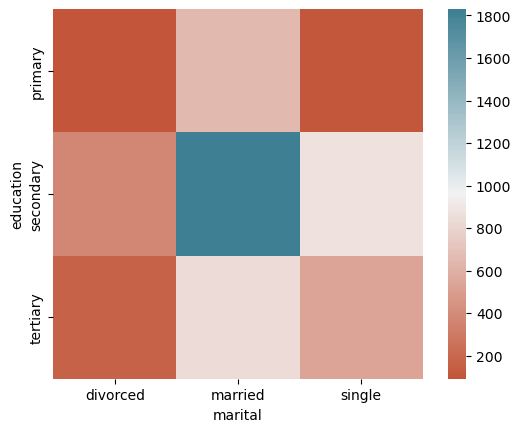

In [28]:
# Тепловая карта для тех кто не открыл депозит
deposit_no = df[df.deposit=='no']
crosstab_no_df = pd.crosstab(deposit_no.education, deposit_no.marital)
print(crosstab_no_df)
ax = sns.heatmap(
    crosstab_no_df,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
)

## Часть 3: преобразование данных

### Задание 1

In [29]:
# преобразуйте уровни образования
# Создание экземпляра класса LabelEncoder()
lab_enc = LabelEncoder()

# Кодирование признака
df['education'] = lab_enc.fit_transform(df['education'])
df['education'].value_counts()
df['education'].sum()
# df.job.nunique()+df.marital.nunique()+df.contact.nunique()+df.month.nunique()

11995

### Задания 2 и 3

In [30]:
# преобразуйте бинарные переменные в представление из нулей и единиц
# Для начала найдем все бинарные признаки
binar_col = []
for i in df.columns:
    if df[i].nunique() == 2:
        binar_col.append(i)
binar_col  
# мы получили списов с бинарными признаками, теперь воспользуемся кодировщиком
# OneHotEncoder
for i in binar_col:
    df[i] = lab_enc.fit_transform(df[i])

import statistics
print(round(statistics.stdev(df['deposit']), 3))
round(df['default'].mean() + df['housing'].mean() + df['loan'].mean(), 3)
binar_col

0.499


['default', 'housing', 'loan', 'deposit']

### Задание 4

In [31]:
# создайте дамми-переменные
df_dammy = pd.get_dummies(df)
print(df_dammy.columns.nunique()-1)


49


### Задания 5 и 6

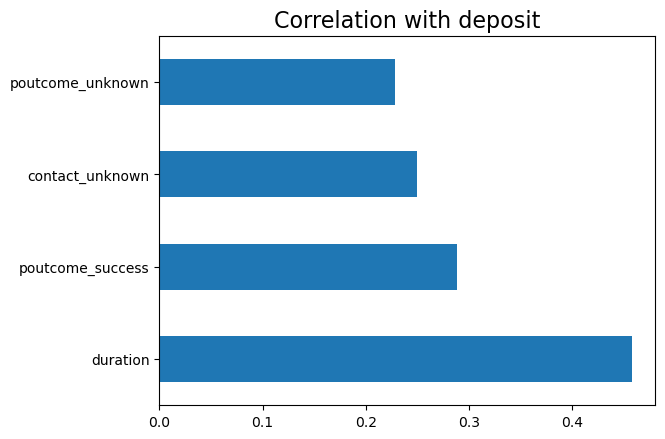

In [32]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности
df_dammy.corr()['deposit'].apply(lambda x: abs(x)).sort_values(ascending=False)[1:5].plot.barh()
plt.title("Correlation with deposit", fontsize = 16)
plt.show()
df = df_dammy

### Задания 7 и 8

In [33]:
X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [34]:
# рассчитайте необходимые показатели
y_test.count()
round(y_test.mean(), 2)

0.46

### Задание 9

In [35]:
# 2 вариант через compress 
from itertools import compress

skb = SelectKBest(f_classif, k=15).fit(X_train, y_train)
mask = skb.get_support()
name_col = X_train.columns.values

columns_name = list(compress(name_col, mask))

In [36]:
columns_name

['balance',
 'housing',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'contact_cellular',
 'contact_unknown',
 'month_mar',
 'month_may',
 'month_oct',
 'month_sep',
 'poutcome_success',
 'poutcome_unknown',
 'age_group_60+']

### Задание 10

In [37]:
df = df[['balance', 'housing', 'duration', 'campaign', 'pdays', 
         'previous', 'age_group_60+', 'contact_cellular', 'contact_unknown',
         'month_mar', 'month_may', 'month_oct', 'month_sep', 'poutcome_success', 'poutcome_unknown', 'deposit']]

X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(X_test_scaled[:, 0].mean())  # для признака balance
df.columns

0.46823674223097866


Index(['balance', 'housing', 'duration', 'campaign', 'pdays', 'previous',
       'age_group_60+', 'contact_cellular', 'contact_unknown', 'month_mar',
       'month_may', 'month_oct', 'month_sep', 'poutcome_success',
       'poutcome_unknown', 'deposit'],
      dtype='object')

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [38]:
import sklearn
from sklearn.metrics import accuracy_score
# обучите логистическую регрессию и рассчитайте метрики качества
log_reg = linear_model.LogisticRegression(
    solver='sag', 
    random_state=42, 
    max_iter=1000 )

log_reg.fit(X_train_scaled, y_train)
y_train_pred_log_reg = log_reg.predict(X_train_scaled)
y_test_pred_log_reg = log_reg.predict(X_test_scaled)

print(f"accuracy_score на тренироваочных данных {round(sklearn.metrics.accuracy_score(y_train, y_train_pred_log_reg), 2)}")
print(f"accuracy_score на тестовых данных {round(sklearn.metrics.accuracy_score(y_test, y_test_pred_log_reg), 2)}")

accuracy_score на тренироваочных данных 0.82
accuracy_score на тестовых данных 0.81


### Задания 2,3,4

In [39]:
# обучите решающие деревья, настройте максимальную глубину
dt = tree.DecisionTreeClassifier(
    criterion='entropy',
    random_state=42,
    max_depth = 6
)

dt.fit(X_train_scaled, y_train)
y_train_pred_dt = dt.predict(X_train_scaled)
y_test_pred_dt = dt.predict(X_test_scaled)
print(f"accuracy_score на тренироваочных данных {round(sklearn.metrics.accuracy_score(y_train, y_train_pred_dt), 2)}")
print(f"accuracy_score на тестовых данных {round(sklearn.metrics.accuracy_score(y_test, y_test_pred_dt), 2)}")

accuracy_score на тренироваочных данных 0.81
accuracy_score на тестовых данных 0.8


### Задание 5

In [40]:
# GridSearchCV на DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

parameters =  {'min_samples_split': [2, 5, 7, 10], 'max_depth':[3,5,7]}

model_cv = GridSearchCV(tree.DecisionTreeClassifier(), 
                        parameters,
                        cv=3, scoring=('f1'), 
                        return_train_score=True)

%time model_cv.fit(X_train_scaled, y_train) 
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred_dt)))
print("accuracy на тестовом наборе: {:.2f}".format(model_cv.score(X_test_scaled, y_test)))
print("Наилучшие значения гиперпараметров: {}".format(model_cv.best_params_))

Wall time: 323 ms
f1_score на тестовом наборе: 0.79
accuracy на тестовом наборе: 0.78
Наилучшие значения гиперпараметров: {'max_depth': 7, 'min_samples_split': 2}


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [41]:
# обучите на ваших данных случайный лес
rf = ensemble.RandomForestClassifier(
    n_estimators=100,
    criterion='gini',
    min_samples_leaf=5,
    max_depth=10,
    random_state=42
)
#Обучаем модель
%time rf.fit(X_train_scaled, y_train)
y_test_pred_rf = rf.predict(X_test_scaled)

Wall time: 283 ms


In [42]:
print('test: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred_rf)))

test: 0.82


In [43]:
from sklearn.metrics import recall_score
round(sklearn.metrics.recall_score(y_test, y_test_pred_rf), 2)

0.82

### Задания 2 и 3

In [44]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом
from sklearn.ensemble import GradientBoostingClassifier
gbс = GradientBoostingClassifier(
    learning_rate = 0.05,
    n_estimators = 300,
    min_samples_leaf = 5,
    max_depth = 5,
    random_state = 42
)
%time gbс.fit(X_train_scaled, y_train)
y_test_pred_gbс = gbс.predict(X_test_scaled)


Wall time: 2.24 s


In [45]:
from sklearn.metrics import f1_score
round(f1_score(y_test, y_test_pred_gbс), 2)

0.81

### Задание 4

In [46]:
# объедините уже известные вам алгоритмы с помощью стекинга
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV
estimators = [
    ('dt', tree.DecisionTreeClassifier(
        criterion='entropy',
        min_samples_leaf=5,
        max_depth=6,
        random_state=42
        )
    ),
    ('log_reg', linear_model.LogisticRegression(
        solver='sag',
        random_state=42 
        )
    ),
    ('gb', ensemble.GradientBoostingClassifier(
        learning_rate=0.05,
        n_estimators=300,
        min_samples_leaf=5,
        max_depth=5,
        random_state=42
        )
    )
]


In [47]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
#Создаем объект класса стекинг
stack = ensemble.StackingClassifier(
    estimators,
    final_estimator=linear_model.LogisticRegression(random_state=42)
)
 
#Обучаем модель
%time stack.fit(X_train, y_train)

y_pred_stack = stack.predict(X_test)
print(f'Качество предсказания по MSE для стекинга {round(sklearn.metrics.accuracy_score(y_test, y_pred_stack),2)}')

Wall time: 12.3 s
Качество предсказания по MSE для стекинга 0.82


### Задание 5

In [48]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга
from sklearn.feature_selection import RFE
estimator = GradientBoostingClassifier()
selector = RFE(estimator, n_features_to_select=3, step=1)
selector = selector.fit(X_train, y_train)

print(selector.get_feature_names_out())
print(X_train.columns)
selector.ranking_


['duration' 'contact_unknown' 'poutcome_success']
Index(['balance', 'housing', 'duration', 'campaign', 'pdays', 'previous',
       'age_group_60+', 'contact_cellular', 'contact_unknown', 'month_mar',
       'month_may', 'month_oct', 'month_sep', 'poutcome_success',
       'poutcome_unknown'],
      dtype='object')


array([ 5,  3,  1,  9,  2, 12,  6, 13,  1,  4, 11,  7,  8,  1, 10])

### Задания 6,7,8

In [49]:
!pip install optuna

Defaulting to user installation because normal site-packages is not writeable


In [50]:
import optuna
print(optuna.version)

<module 'optuna.version' from 'C:\\Users\\Башир\\AppData\\Roaming\\Python\\Python39\\site-packages\\optuna\\version.py'>


In [67]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna
import optuna

def optuna_rf(trial):
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

# Создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42)
#     Обучаем модель
  model.fit(X_train_scaled, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train_scaled))
         


  return score

study = optuna.create_study(study_name='RandomForestClassifier', direction="maximize")

study.optimize(optuna_rf, n_trials=10)
model = ensemble.RandomForestClassifier(**study.best_params,random_state=42, )

[I 2022-11-24 09:11:34,000] A new study created in memory with name: RandomForestClassifier
[I 2022-11-24 09:11:34,628] Trial 0 finished with value: 0.8487697853001098 and parameters: {'n_estimators': 187, 'max_depth': 19, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.8487697853001098.
[I 2022-11-24 09:11:35,054] Trial 1 finished with value: 0.8704402515723271 and parameters: {'n_estimators': 113, 'max_depth': 20, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.8704402515723271.
[I 2022-11-24 09:11:35,794] Trial 2 finished with value: 0.8683755307438277 and parameters: {'n_estimators': 199, 'max_depth': 19, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.8704402515723271.
[I 2022-11-24 09:11:36,525] Trial 3 finished with value: 0.8890629896584142 and parameters: {'n_estimators': 188, 'max_depth': 29, 'min_samples_leaf': 3}. Best is trial 3 with value: 0.8890629896584142.
[I 2022-11-24 09:11:36,848] Trial 4 finished with value: 0.8348129359543438 and parameters: {'n_

In [69]:
model = ensemble.RandomForestClassifier(**study.best_params,random_state=42, )
#     Обучаем модель
model.fit(X_train_scaled, y_train)


from sklearn.metrics import accuracy_score
y_pred = model.predict(X_test_scaled)

print(round(f1_score(y_pred, y_test),2))
print(round(accuracy_score(y_pred, y_test),2))

0.81
0.82
